# Hyperparameter Tuning

In [17]:
import os
import sys
import tempfile
import subprocess
from IPython.display import Image

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn
import astropy.units as u
from astropy.coordinates import SkyCoord
from sunpy.map import Map,GenericMap
from sklearn.preprocessing import LabelEncoder,OneHotEncoder,scale
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.linear_model import LinearRegression

sys.path.append('../paper/python/')
from formatting import get_figsize,heating_palette,qualitative_palette,heating_cmap
from classify import prep_data, classify_ar

import warnings
warnings.filterwarnings('ignore',category=UserWarning,)

%matplotlib inline

In [31]:
def preview_classification(fmap, pmaps):
    # frequency map
    fig = plt.figure(figsize=(10,10))
    m = GenericMap(fmap, meta)
    m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                 SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
    ax = fig.add_subplot(111, projection=m)
    im = m.plot(
        axes=ax,
        title=False,
        annotate=False,
        vmin=-0.5,
        vmax=2.5,
        cmap=heating_cmap()
    )
    ax.grid(alpha=0)
    # Axes and ticks
    lon, lat = ax.coords
    lon.set_axislabel('Helioprojective Longitude',)
    lat.set_axislabel('Helioprojective Latitude',)
    lat.set_ticklabel(rotation='vertical')
    lon.set_ticks(number=4)
    lat.set_ticks(number=2)
    # Colorbar
    cax = fig.add_axes([
        ax.get_position().get_points()[0,0],
        ax.get_position().get_points()[1,0],
        ax.get_position().get_points()[1,0] - ax.get_position().get_points()[0,0],
        0.03
    ])
    cbar = fig.colorbar(im, cax=cax,orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    cbar.set_ticks([-0.25,1,2.25])
    cbar.ax.set_xticklabels([h.split('_')[0].capitalize() for h in heating],)
    cbar.ax.tick_params(axis='x',which='both',length=0)
    
    # Probability map
    fig = plt.figure(figsize=(20,7))
    plt.subplots_adjust(wspace=0.03,hspace=0.03)
    axes = []
    for i,h in enumerate(heating):
        m = GenericMap(pmaps[h], meta)
        m = m.submap(SkyCoord(Tx=-410*u.arcsec,Ty=-325*u.arcsec,frame=m.coordinate_frame),
                     SkyCoord(Tx=-225*u.arcsec,Ty=-150*u.arcsec,frame=m.coordinate_frame))
        ax = fig.add_subplot(1, 3, i+1, projection=m)
        axes.append(ax)
        im = m.plot(axes=ax,
                    annotate=False,
                    title=False,
                    vmin=0,
                    vmax=1,
                    cmap='viridis',
                   )
        ax.grid(alpha=0)
        lon,lat = ax.coords
        lon.set_ticks(number=3)
        lat.set_ticks(number=3)
        if i == 0:
            lon.set_axislabel('Helioprojective Longitude [arcsec]',)
            lat.set_axislabel('Helioprojective Latitude [arcsec]', )
            lat.set_ticklabel(rotation='vertical')
        else:
            lat.set_ticklabel_visible(False)
            lon.set_ticklabel_visible(False)
        ax.set_title(h.split('_')[0].capitalize(),)
    cax = fig.add_axes([
        axes[0].get_position().get_points()[0,0],
        axes[-1].get_position().get_points()[1,0],
        axes[-1].get_position().get_points()[1,0]-axes[0].get_position().get_points()[0,0],
        0.03
    ])
    cbar = fig.colorbar(im, cax=cax, orientation='horizontal')
    cbar.ax.xaxis.set_ticks_position('top')
    

In [2]:
heating = ['high_frequency', 'intermediate_frequency', 'low_frequency',]
channels = [94,131,171,193,211,335]
channel_pairs = [(94,335),
                 (94,171),
                 (94,193),
                 (94,131),
                 (94,211),
                 (335,131),
                 (335,193),
                 (335,211), 
                 (335,171),
                 (211,131),
                 (211,171),
                 (211,193),
                 (193,171),
                 (193,131),
                 (171,131),]
correlation_threshold = 0.1
rsquared_threshold = 0.75

In [30]:
meta = Map('../paper/data/observations/timelag_171_131.fits').meta

In [3]:
file_format = '../paper/data/{}/{}_{}_{}.fits'

In [4]:
X, Y, X_observation, bad_pixels = prep_data(
    '../paper/data/',
    channel_pairs,
    heating,
    correlation_threshold=correlation_threshold,
    rsquared_threshold=rsquared_threshold,
    scale_slope=False,
    scale_timelag=False,
    scale_correlation=False,
)

In [7]:
grid_parameters = {
    'n_estimators': [200],#[100, 200, 500],
    'max_features': ['sqrt'],
    'max_depth': [None],#[10, 20, 50],
    'min_samples_leaf': [1,0.05,0.01,],
    'min_samples_split': [2, 0.01, 0.001],
    'criterion': ['gini'],
    'bootstrap': [True,],
    'oob_score': [True,],
    'max_leaf_nodes': [None],
    'min_impurity_decrease': [0],
}

In [8]:
rf = RandomForestClassifier()

In [21]:
clf_rcv = RandomizedSearchCV(
    rf,
    grid_parameters,
    n_iter=10,
    n_jobs=-1,
    cv=10,
    scoring='f1_macro',
)

In [22]:
#X_train_dask, X_test_dask, Y_train_dask, Y_test_dask = dask_train_test_split(
#    dask.array.from_array(X_scaled,chunks=X_scaled.shape),
#    dask.array.from_array(Y_encoded,chunks=Y_encoded.shape),
#    test_size=0.33,
#)
X_train, X_test, Y_train, Y_test = train_test_split(
        X, Y, test_size=0.33)

In [23]:
clf_rcv.fit(X_train, Y_train)

RandomizedSearchCV(cv=10, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [200], 'max_features': ['sqrt'], 'max_depth': [None], 'min_samples_leaf': [1, 0.05, 0.01], 'min_samples_split': [2, 0.01, 0.001], 'criterion': ['gini'], 'bootstrap': [True], 'oob_score': [True], 'max_leaf_nodes': [None], 'min_impurity_decrease': [0]},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='f1_macro', verbose=0

In [24]:
clf_rcv.best_params_

{'oob_score': True,
 'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'min_impurity_decrease': 0,
 'max_leaf_nodes': None,
 'max_features': 'sqrt',
 'max_depth': None,
 'criterion': 'gini',
 'bootstrap': True}

In [25]:
1. - clf_rcv.best_estimator_.score(X_test,Y_test)

0.027371517280823543

In [26]:
clf_rcv.scorer_

make_scorer(f1_score, pos_label=None, average=macro)

In [28]:
fmap,pmaps,clf,err = classify_ar(clf_rcv.best_params_, X, Y, X_observation, bad_pixels)

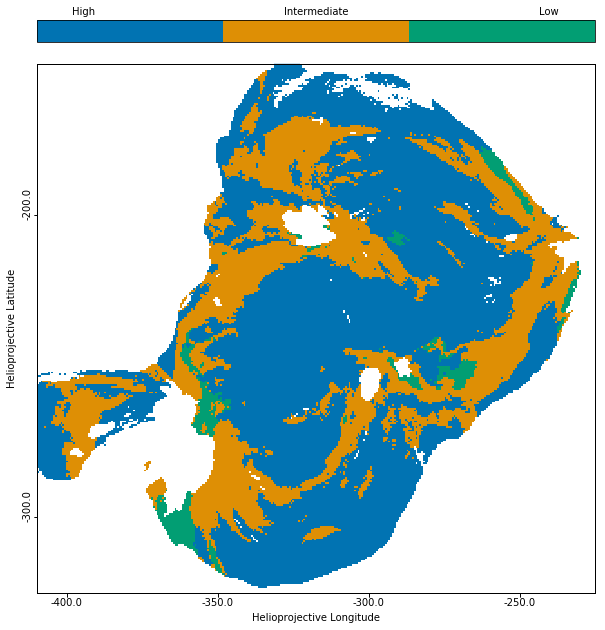

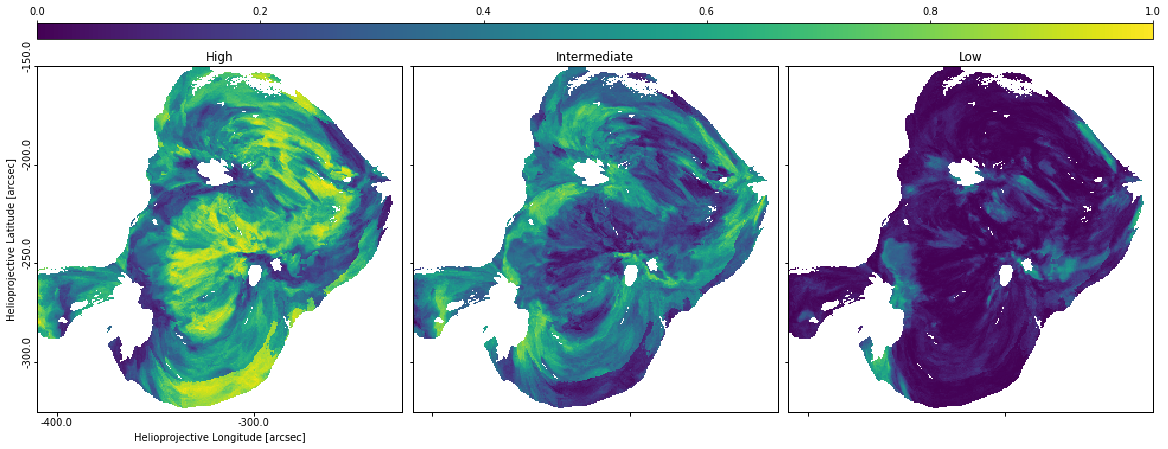

In [32]:
preview_classification(fmap,pmaps,)

In [33]:
X.shape

(111261, 31)

In [35]:
bad_pixels.shape

(500, 500)

In [36]:
np.sqrt(31)

5.5677643628300215